# Import dependencies

In [11]:
# Reload modules whenever underlying code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# pdb will automatically run on exceptions
#%pdb on # currently not working due to https://github.com/ipython/ipykernel/issues/422

In [13]:
# import os

# # Only occupy one GPU, as in https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# # Only allocate GPU memory as needed
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# # Suppress tf warning messages
# os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

In [14]:
%matplotlib inline
from sgm.dependencies import *

# Initialize untrained agent

In [15]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.enable_eager_execution(config=config)

In [16]:
# tf.debugging.set_log_device_placement(True)
tf.test.is_gpu_available()

True

In [17]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [18]:
tf.reset_default_graph()

In [19]:
from sgm.envs import env_load_fn
from sgm.agent import UvfAgent

# If you change the environment parameters below, make sure to run
# tf.reset_default_graph() in the cell above before training.
max_episode_steps = 30
env_name = 'Spiral5x5'  # Choose one of the environments shown above. 
resize_factor = 5  # Inflate the environment to increase the difficulty.
thin = True # If True, resize by expanding open space, not walls, to make walls thin
desc_name = "thinned_" + env_name.lower() if thin else env_name.lower()

base_dir = os.path.join(os.getcwd(), os.pardir, "agents")
model_dir = os.path.join(base_dir, desc_name)

tf_env = env_load_fn(env_name, max_episode_steps,
                     resize_factor=resize_factor,
                     terminate_on_timeout=False,
                     thin=thin)
eval_tf_env = env_load_fn(env_name, max_episode_steps,
                          resize_factor=resize_factor,
                          terminate_on_timeout=True,
                          thin=thin)

agent = UvfAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    max_episode_steps=max_episode_steps,
    use_distributional_rl=True,
    ensemble_size=3)

/home/blbudima/miniconda3/envs/sgm/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Train the agent

In [20]:
# from sgm.trainer import train_eval

# train_eval(agent,
#           tf_env,
#           eval_tf_env,
#           initial_collect_steps=1000,
#           eval_interval=1000,
#           num_eval_episodes=10,
#           num_iterations=30000,
#           save_model_dir=model_dir,
#           experiment_name=f"{env_name}_coordinate_{max_episode_steps}steps")

INFO:tensorflow:random_seed = 0


KeyboardInterrupt: 

# Load trained model into agent

In [21]:
filename = "Spiral5x5_coordinate_30steps-May-11-2021-05-58-39-PM/ckpt/"
checkpoint_file = os.path.join(model_dir, filename)

ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=agent)
manager = tf.train.CheckpointManager(ckpt, checkpoint_file, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

# Fill replay buffer with random prefectly explored data

In [22]:
from sgm.envs import *

#@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
replay_buffer_size = 2000 #@param {min:100, max: 1000, step: 100, type:"slider"}

eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=0.0,
    min_dist=0,
    max_dist=10)
rb_vec = []
for it in range(replay_buffer_size):
    ts = eval_tf_env.reset()
    rb_vec.append(ts.observation['observation'].numpy()[0])
rb_vec = np.array(rb_vec)

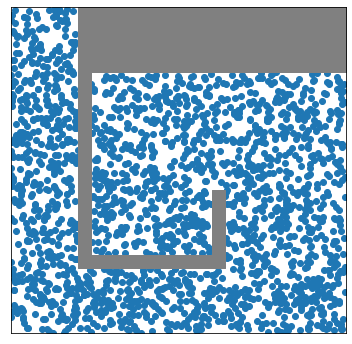

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(*rb_vec.T)
plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
plt.show()

# Calculate qvalue distances

In [24]:
pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()

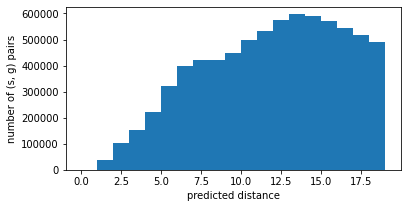

In [25]:
plt.figure(figsize=(6, 3))
plt.hist(pdist.flatten(), bins=range(20))
plt.xlabel('predicted distance')
plt.ylabel('number of (s, g) pairs')
plt.show()

# Tune edge cutoff

Plotting 194 nodes and 6826 edges


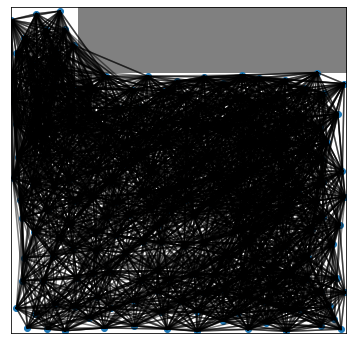

In [33]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=30) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=30)

from sgm.utils.visualization import *
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 970 edges


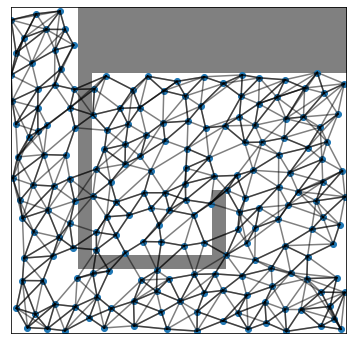

In [34]:
search_policy.keep_k_nearest(5)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 776 edges


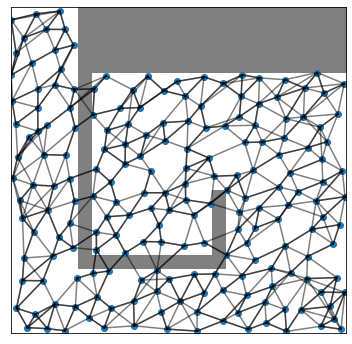

In [35]:
search_policy.keep_k_nearest(4)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 582 edges


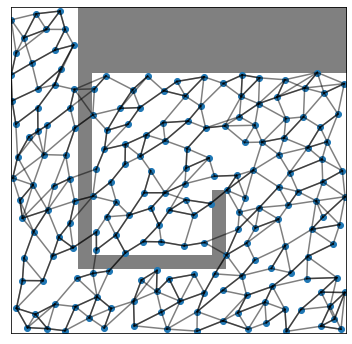

In [36]:
search_policy.keep_k_nearest(3)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 388 edges


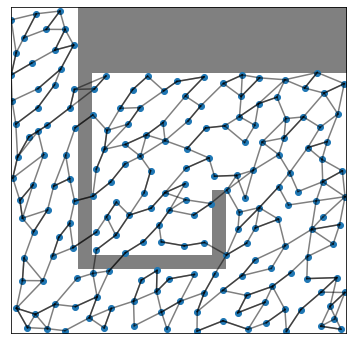

In [37]:
search_policy.keep_k_nearest(2)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 194 edges


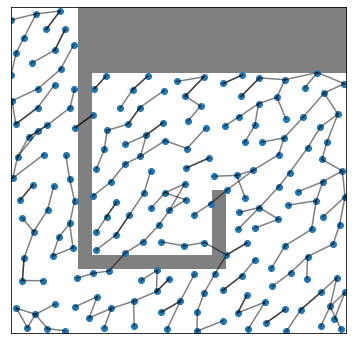

In [38]:
search_policy.keep_k_nearest(1)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

# Calculate Euclidean distances

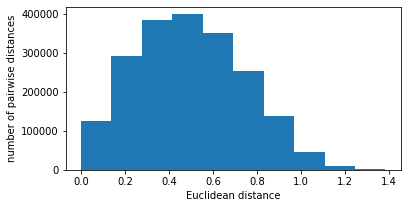

In [39]:
from scipy.spatial import distance
euclidean_dists = distance.pdist(rb_vec)

plt.figure(figsize=(6, 3))
plt.hist(euclidean_dists.flatten())
plt.xlabel('Euclidean distance')
plt.ylabel('number of pairwise distances')
plt.show()

# Initialize SGM search policy

In [40]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=30) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=30)

# Cleanup and evaluate SGM

In [41]:
from sgm.evaluation import cleanup_and_eval

logdir = os.path.join(os.getcwd(), os.pardir, "logs")
eval_difficulty = 0.95
k_nearest = 5
eval_trials = 20
total_cleanup_steps = 50000
eval_period = 5000

logfolder = cleanup_and_eval(search_policy,
                             search_policy_type,
                             desc_name,
                             eval_tf_env,
                             logdir,
                             eval_difficulty=eval_difficulty,
                             k_nearest=k_nearest,
                             eval_trials=eval_trials,
                             total_cleanup_steps=total_cleanup_steps,
                             eval_period=eval_period)

SGM has initial success rate 0.00
Evaluated initial SGM success rate in 770.24 seconds
After filtering and 0 cleanup steps, SGM has success rate 0.00
Took 5000 cleanup steps and evaluated SGM success rate in 1201.96 seconds
After filtering and 5000 cleanup steps, SGM has success rate 0.00
Took 5000 cleanup steps and evaluated SGM success rate in 1233.59 seconds
After filtering and 10000 cleanup steps, SGM has success rate 0.75
Took 5000 cleanup steps and evaluated SGM success rate in 1014.34 seconds
After filtering and 15000 cleanup steps, SGM has success rate 0.85
Took 5000 cleanup steps and evaluated SGM success rate in 893.01 seconds
After filtering and 20000 cleanup steps, SGM has success rate 0.95
Took 5000 cleanup steps and evaluated SGM success rate in 862.47 seconds
After filtering and 25000 cleanup steps, SGM has success rate 0.90
Took 5000 cleanup steps and evaluated SGM success rate in 892.15 seconds
After filtering and 30000 cleanup steps, SGM has success rate 1.00
Took 500

# Load cleanup graphs

In [42]:
from sgm.utils.visualization import *

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_initial"))
initial_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_0_cleanup_steps/"))
filtered_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_{}_cleanup_steps/".format(total_cleanup_steps)))
cleaned_graph = search_policy._g.copy()

pruned_graph = nx.difference(filtered_graph, cleaned_graph)

# Visualize cleanup graphs

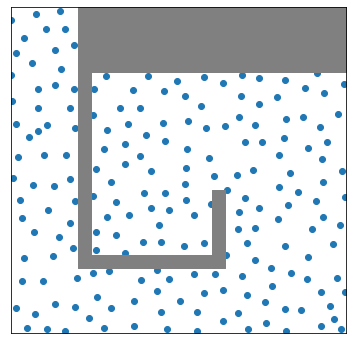

In [43]:
plot_points(search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 6826 edges


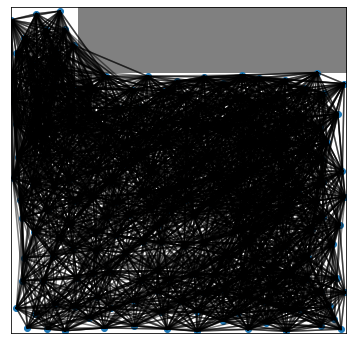

In [44]:
plot_graph(initial_graph, search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 970 edges


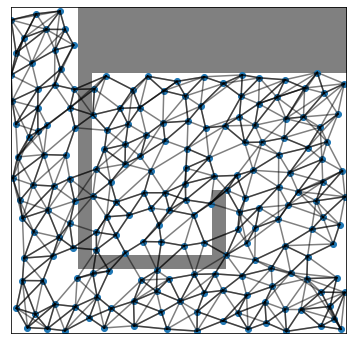

In [45]:
plot_graph(filtered_graph, search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 911 edges


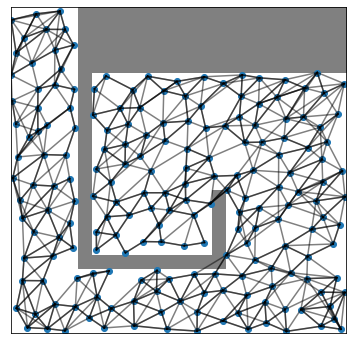

In [46]:
plot_graph(cleaned_graph, search_policy.rb_vec, eval_tf_env)

Plotting 194 nodes and 59 edges


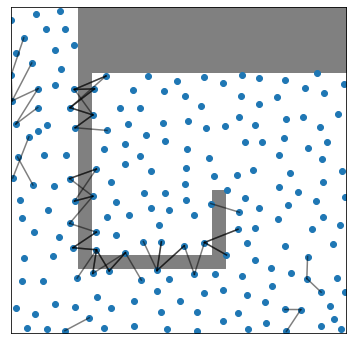

In [47]:
plot_graph(pruned_graph, search_policy.rb_vec, eval_tf_env)